## 평균회귀 전략 백테스트
추세추종 전략은 주가가 동일한 방향으로 지속된다고 보는 반면, 평균회귀 전략은 주가가 평균으로 회귀한다고 보며 이에 베팅한다. 주가가 무한정 한방향으로 지속될 수는 없기에 추세추종 전략과 평균회귀 전략을 잘 조합할 필요가 있다.

## RSI를 이용한 전략
RSI는 일정기간 동안 주가의 상승폭과 하락폭의 크기를 비교해 상승과 하락의 상대적인 강도를 나타낸 지표로써, 일반적으로 
- RSI가 70 이상일 경우 과매수 구간으로써 매도할 때를, 
- 30 이하일 경우 과매도 구간으로써 매수해야 할 때로 여겨진다. 
이에 대한 백테스트를 실행해보도록 하자.

In [21]:
import talib
import bt
import yfinance as yf
import FinanceDataReader as fdr
import pandas as pd

In [23]:
stock_list = [["삼성전자", "005930"]]

In [24]:
df_list = [fdr.DataReader(code, '2019-01-01', '2023-06-23')['Close'] for name, code in stock_list]


In [26]:
df_list

[Date
 2019-01-02    38750
 2019-01-03    37600
 2019-01-04    37450
 2019-01-07    38750
 2019-01-08    38100
               ...  
 2023-06-19    71200
 2023-06-20    71400
 2023-06-21    70500
 2023-06-22    71300
 2023-06-23    71600
 Name: Close, Length: 1106, dtype: int64]

In [27]:
df = yf.download('005930.KS','2020-01-01')

[*********************100%***********************]  1 of 1 completed


In [34]:
df = df['Close']

### RSI 신호 만들기

1. 먼저 apply() 함수 내부에 RSI()을 이용해 14일 기준 RSI를 구한다. 
2. 그 후 RSI가 70을 초과하면 -1(숏 포지션), 
3. 30 미만이면 1(롱 포지션), 
4. 30과 70 사이면 0(뉴트럴)인 신호를 만든다.

In [35]:
df_rsi = df.apply(lambda x: talib.RSI(x, 14))

signal = df_rsi.copy()
signal[df_rsi > 70] = -1
signal[df_rsi < 30] = 1
signal[(df_rsi <= 70) & (df_rsi >= 30)] = 0
signal[signal.isnull()] = 0

TypeError: Argument 'real' has incorrect type (expected numpy.ndarray, got float)

먼저 apply() 함수 내부에 RSI()을 이용해 14일 기준 RSI를 구한다. 그 후 RSI가 70을 초과하면 -1(숏 포지션), 30 미만이면 1(롱 포지션), 30과 70 사이면 0(뉴트럴)인 신호를 만든다.

In [30]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

C:\Users\com\AppData\Local\Temp\ipykernel_17080\4104816286.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs[0])
C:\Users\com\AppData\Local\Temp\ipykernel_17080\4104816286.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax2 = plt.subplot(gs[1])


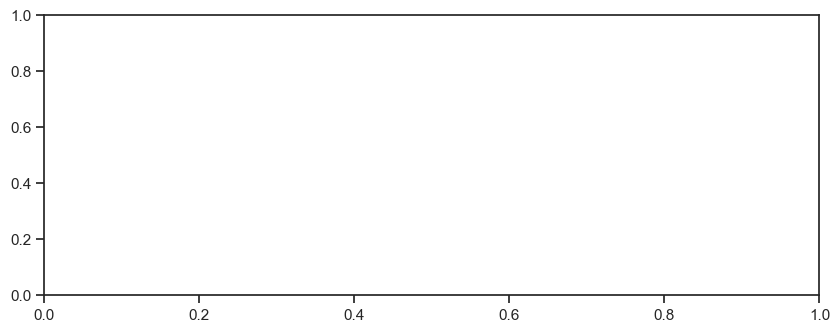

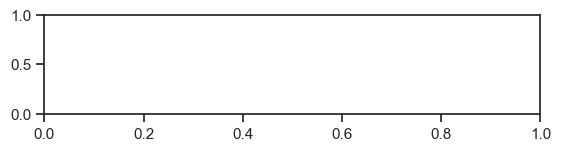

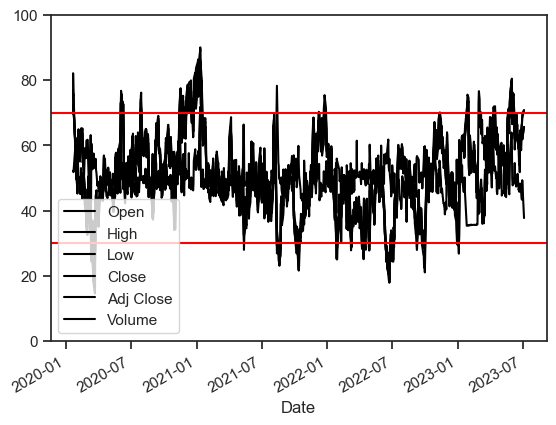

In [31]:
fig = plt.subplots(figsize=(10, 6), sharex=True)
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[2, 1])

ax1 = plt.subplot(gs[0])
ax1 = df.plot()
ax1.set_xlabel('')
ax1.axes.xaxis.set_ticks([])

ax2 = plt.subplot(gs[1])
ax2 = df_rsi.plot(color='black', ylim=[0, 100])
ax2 = plt.axhline(y=30, color='red', linestyle='-')
ax2 = plt.axhline(y=70, color='red', linestyle='-')

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)


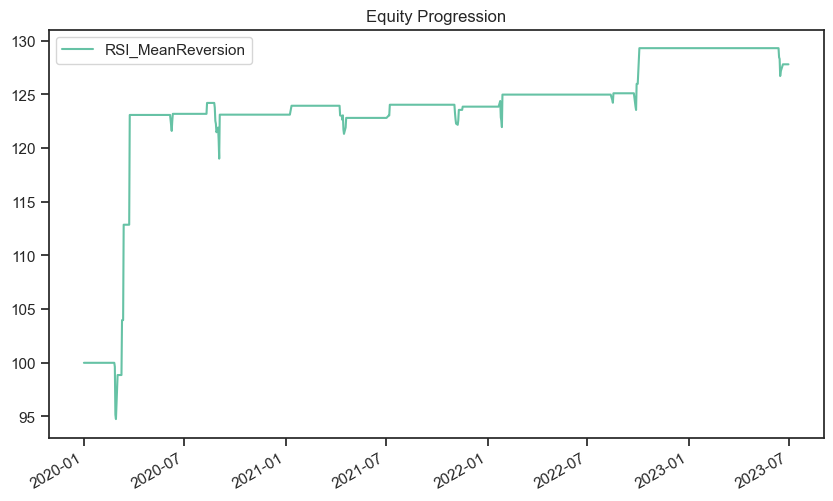

In [11]:
strategy = bt.Strategy('RSI_MeanReversion',
                       [bt.algos.WeighTarget(signal),
                        bt.algos.Rebalance()])
backtest = bt.Backtest(strategy, data)
result = bt.run(backtest)

result.plot(figsize=(10, 6))
plt.show()

RSI를 이용하여 트레이딩을 할 경우 장기간으로 큰 손실없이 잘 작동하지만, 과매수 혹은 과매도로 인한 투자 신호가 나타나는 경우가 드물어 누적수익률 자체도 그렇게 높지 않다. 반면 2020년의 경우 추세추종 전략과는 반대로 3월 급락장에서 과매도 신호로 인해 매수를 함으로써, 반등으로 인해 상당한 수익을 거두기도 한다. 이처럼 추세추종과 평균회귀는 서로 상반되는 특징이 있으므로, 이를 잘 조합하면 훨씬 안정적인 수익을 거둘 수 있는 트레이딩 전략을 개발할 수도 있다.

성과 중 주요 지표를 확인해보도록 하자.

In [12]:
result.stats.loc[['total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe']]

,RSI_MeanReversion
total_return,0.278066
cagr,0.072755
daily_vol,0.087741
max_drawdown,-0.052415
calmar,1.388055
daily_sharpe,0.843095


## 볼린저 밴드를 이용한 전략
이번에는 볼린저 밴드를 이용한 평균회귀 전략을 백테스트 해보도록 하겠다. 볼린저밴드는 이동평균선을 중심으로 일정 표준편차를 상한선과 하한선으로 설정한 밴드다. 주가가 정규분포를 따른다면 주가의 움직임은 상한선과 하한선으로 구성된 밴드 내에서만 움직일 확률이 높다. 따라서 주가가 상한선 위에 있다는 것은 과매수 상태이므로 하락할 가능성이 높으르로 숏 포지션을, 하단선 아래에 있다는 것은 과매도 상태이므로 상승할 가능성이 높으므로 롱 포지션을 취한다.

In [51]:
data_1 = bt.get('SPY',start='2010-01-01')
data_1.tail()

[*********************100%***********************]  1 of 1 completed


,spy
Date,
2023-06-26,431.440002
2023-06-27,436.170013
2023-06-28,436.390015
2023-06-29,438.109985
2023-06-30,443.279999


In [52]:
upper_2sd, mid_2sd, lower_2sd = talib.BBANDS(data_1['spy'],
                                             nbdevup=2,
                                             nbdevdn=2,
                                             timeperiod=20)

bb = pd.concat([upper_2sd, mid_2sd, lower_2sd, data_1['spy']], axis=1)
bb.columns = ['Upper Band', 'Mid Band', 'Lower Band','spy']

<Axes: xlabel='Date'>

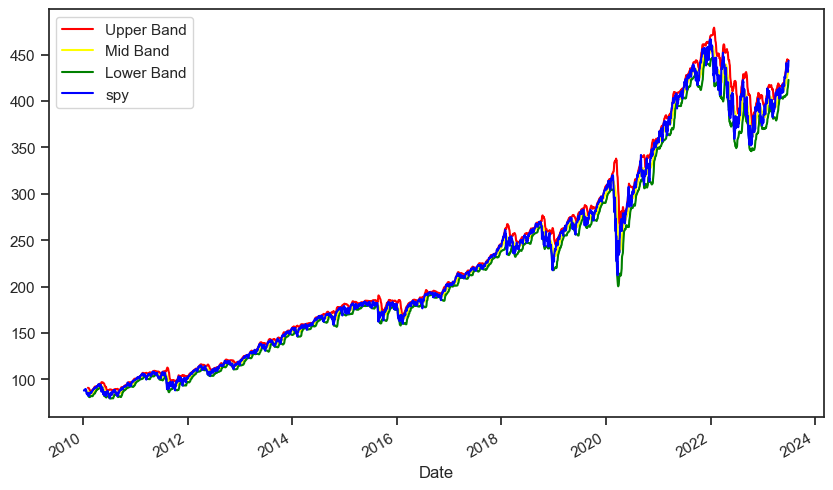

In [61]:
bb.plot(figsize=(10,6),
       color = {
       'Upper Band' : 'red',
       'Mid Band' : 'yellow',
       'Lower Band' : 'Green',
       'spy':'blue'})

BBANDS() 함수를 이용해 20일 기준 2 표준편차에 해당하는 볼린저 밴드의 상, 중, 하단 값을 계산한 후 하나의 데이터프레임으로 묶어준다.

In [62]:
import numpy as np

signal = data_1.copy()
signal['spy'] = np.nan

signal[bb['spy'] > bb['Upper Band']] = -1
signal[bb['spy'] < bb['Lower Band']] = 1
signal[signal.isnull()] = 0

주가가 상한선 위에 있을 경우 -1(숏 포지션), 주가가 하한선 아래에 있을 경우 1(롱 포지션), 그 외의 경우 0(뉴트럴)의 신호를 만둔다. 해당 신호를 바탕으로 백테스트를 실행해보자.

C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)


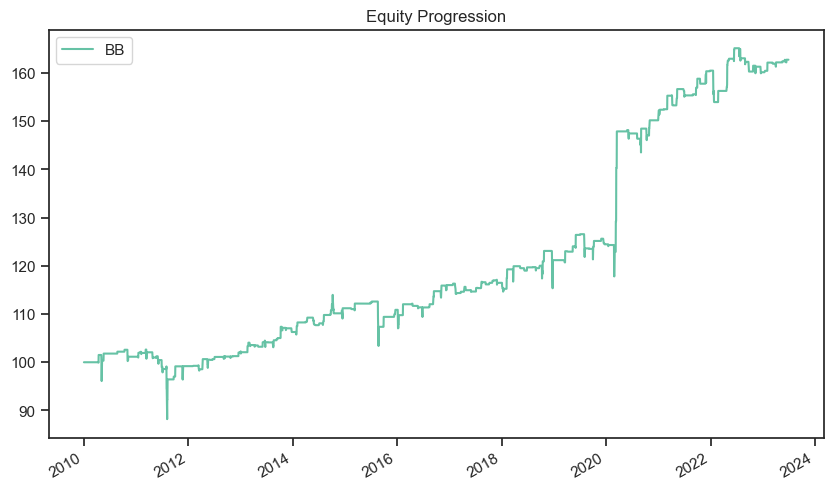

In [63]:
strategy = bt.Strategy('BB',
                       [bt.algos.WeighTarget(signal),
                        bt.algos.Rebalance()])
backtest = bt.Backtest(strategy, data_1)
result = bt.run(backtest)

result.plot(figsize=(10, 6))
plt.show()

RSI와 마찬가지로 볼린저밴드를 이용한 평균회귀 트레이딩을 할 경우에도 장기간으로 큰 손실없이 잘 작동한다. 주요 성과 지표는 다음과 같다.

In [64]:
result.stats.loc[['total_return', 'cagr', 'daily_vol', 'max_drawdown', 'calmar', 'daily_sharpe']]

,BB
total_return,0.627578
cagr,0.036777
daily_vol,0.069385
max_drawdown,-0.140617
calmar,0.261539
daily_sharpe,0.555341


## bt 패키지의 함수
## 마지막으로 bt 패키지의 함수들을 정리해보도록 하겠다.

## 유니버스 선택

- bt.algos.SelectAll(): 모든 종목 선택
- bt.algos.SelectHasData(): 일정 갯수 이상의 데이터가 있는 종목 선택
- bt.algos.SelectMomentum(): 모멘텀 상위 종목 선택, bt.algos.SelectAll()을 먼저 불러와야 함
- bt.algos.SelectWhere(): 입력값이 True 일때만 투자

### 비중 선택

- bt.algos.WeighEqually(): 동일 비중
- bt.algos.WeighSpecified(): 비중 직접 입력. 리밸런싱 마다 동일한 값 적용.
- bt.algos.WeighTarget(signal): 비중 직접 입력. 리밸런싱 마다 입력한 값 적용.
- bt.algos.WeighERC(): 위험균형 전략
- bt.algos.WeighInvVol(): 역변동성 전략
- bt.algos.WeighMeanVar(): 최대샤프지수 전략

### 리밸런싱 시점

- bt.algos.RunOnce(): 처음 한번만 리밸런싱
- bt.algos.RunDaily(): 매일 리밸런싱
- bt.algos.RunMonthly(): 매월 리밸런싱
- bt.algos.RunQuarterly(): 매분기 리밸런싱
- bt.algos.RunWeekly(): 매주 리밸런싱
- bt.algos.RunYearly(): 매년 리밸런싱

### 리밸런싱 방법

- bt.algos.Rebalance(): 선택한 시점과 비중에 따라 리밸런싱
- bt.algos.RebalanceOverTime(): n일에 걸쳐 리밸런싱

### 기타 함수들

- plot_weights(): 투자 비중 출력
- get_security_weights(): 투자 비중을 데이터프레임 형태로 반환
- prices(): 누적수익률을 데이터프레임 형태로 구하기
- prices.rebase(): 특정 시점부터 다시 100으로 환산
- prices.to_returns(): 수익률 계산
- display(): 성과 측정치
- display_monthly_returns(): 월간 수익률 구하기
- turnover(): 회전율 구하기

{note}
위에서 백테스트한 추세추종과 평균회귀 전략의 경우 신호가 발생하면 해당일 종가에 포지션을 취한다고 가정했다. 그러나 현실에서는 종가 직전까지 발생한 신호를 바탕으로 종가에 매매를 하거나 종가로 계산된 신호를 바탕으로 다음날 시가에 매매를 해야하므로, 백테스트의 수익률과 실제 수익률은 상당히 차이가 있을 수 있다. 또한 매매수수료와 시장충격으로 인해 백테스트의 수익률과 실제 수익률간 차이가 발생할 수도 있다.
{note}
크롤링으로 수집한 데이터로 개별 주식에 대한 백테스트를 하기에는 생존 편향, 소급 편향 등의 문제가 있으며, 난이도 역시 매우 높다. 두물머리에서 제공하는 '올라떼' 사이트에서는 전 세계 주식을 대상으로 양질의 데이터를 통한 각종 팩터 모형에 대한 백테스트를 클릭만으로 수행할 수 있으니 이를 참조하기 바란다.